# Combo Sci-Plex training demo Notebook

In [1]:
import sys
#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install cpa-tools
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/theislab/cpa

In [2]:
from sklearn.metrics import r2_score
import numpy as np

import os
os.chdir('/home/mohsen/projects/cpa/')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import cpa
import scanpy as sc

Global seed set to 0


In [4]:
sc.settings.set_figure_params(dpi=100)

In [5]:
data_path = '/home/mohsen/projects/cpa/datasets/combo_sciplex_prep_hvg_filtered.h5ad'

## Data Loading

In [6]:
adata = sc.read(data_path, backup_url='https://drive.google.com/uc?export=download&id=1RRV0_qYKGTvD3oCklKfoZQFYqKJy4l6t')
adata

AnnData object with n_obs × n_vars = 63378 × 5000
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway1', 'pathway2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID', 'condition', 'condition_ID', 'control', 'cell_type', 'smiles_rdkit', 'source', 'sample', 'Size_Factor', 'n.umi', 'RT_well', 'Drug1', 'Drug2', 'Well', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'split', 'condition_old', 'pert_type', 'batch', 'split_1ct_MEC', 'split_2ct_MEC', 'split_3ct_MEC', 'batch_cov', 'batch_cov_cond', 'log_dose'
    var: 'ensembl_id-0', 'ncounts-0', 'ncells-0', 'symbol-0', 'symbol-1', 'id-1', 'n_cells-1', 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_var

## Data preparation

__IMPORTANT__: Currenlty because of the standartized evaluation procedure, we need to provide adata.obs['control'] (0 if not control, 1 for cells to use as control). And we also need to provide de_genes in .uns['rank_genes_groups']. 

In [7]:
adata.obs['dose_value'].value_counts()

1000.0+1000.0    50941
1000.0           10986
1.0               1451
Name: dose_value, dtype: int64

In [8]:
adata.obs['condition_ID'].value_counts()

CHEMBL356066+CHEMBL2170177     3298
46245047+CHEMBL491473          3016
CHEMBL1213492+CHEMBL491473     2783
CHEMBL4297436                  2756
CHEMBL1213492+CHEMBL116438     2736
CHEMBL1213492+CHEMBL1200485    2734
CHEMBL1213492+CHEMBL460499     2692
CHEMBL1213492+CHEMBL601719     2662
CHEMBL1213492+CHEMBL1421       2421
CHEMBL1213492+CHEMBL4297436    2353
CHEMBL1421                     2343
CHEMBL1213492+CHEMBL257991     2260
CHEMBL483254+CHEMBL116438      2244
CHEMBL491473+CHEMBL2170177     2161
CHEMBL483254+CHEMBL1200485     2013
CHEMBL483254+CHEMBL4297436     1971
CHEMBL483254+CHEMBL1421        1955
CHEMBL356066+CHEMBL402548      1939
CHEMBL483254+46245047          1889
CHEMBL356066                   1869
CHEMBL483254+CHEMBL257991      1826
CHEMBL483254+CHEMBL2170177     1814
CHEMBL1213492                  1682
CHEMBL483254+CHEMBL601719      1641
CHEMBL483254                   1578
CHEMBL504                      1451
CHEMBL1213492+CHEMBL109480     1310
CHEMBL356066+CHEMBL1421     

In [9]:
adata.obs['split_1ct_MEC'].value_counts()

train    49683
ood       8209
valid     5486
Name: split_1ct_MEC, dtype: int64

In [10]:
adata.X = adata.layers['counts'].copy()

In [11]:
cpa.CPA.setup_anndata(adata, 
                      perturbation_key='condition_ID',
                      dosage_key='dose_value',
                      control_group='CHEMBL504',
                      batch_key=None,
                      is_count_data=True,
                      categorical_covariate_keys=['cell_type'],
                      max_comb_len=2,
                     )

100%|██████████| 63378/63378 [00:00<00:00, 874070.20it/s]
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


## Training CPA

You can specify all the parameters for the model in a dictionary of parameters. If they are not specified, default values will be selected.

* `ae_hparams` are technical parameters of the architecture of the autoencoder.
    * `n_latent`: number of latent dimensions for the autoencoder
    * `recon_loss`: the type of reconstruction loss function to use
    * `doser_type`: the type of doser to use
    * `n_hidden_encoder`: number of hidden neurons in each hidden layer of the encoder
    * `n_layers_encoder`: number of hidden layers in the encoder
    * `n_hidden_decoder`: number of hidden neurons in each hidden layer of the decoder
    * `n_layers_decoder`: number of hidden layers in the decoder
    * `use_batch_norm_encoder`: if `True`, batch normalization will be used in the encoder
    * `use_layer_norm_encoder`: if `True`, layer normalization will be used in the encoder
    * `use_batch_norm_decoder`: if `True`, batch normalization will be used in the decoder
    * `use_layer_norm_decoder`: if `True`, layer normalization will be used in the decoder
    * `dropout_rate_encoder`: dropout rate used in the encoder
    * `dropout_rate_decoder`: dropout rate used in the decoder
    * `variational`: if `True`, variational autoencoder will be employed as the main perturbation response predictor
    * `seed`: number for setting the seed for generating random numbers.
* `trainer_params` are training parameters of CPA.
    * `n_epochs_adv_warmup`: number of epochs for adversarial warmup
    * `n_epochs_kl_warmup`: number of epochs for KL divergence warmup
    * `n_epochs_pretrain_ae`: number of epochs to pre-train the autoencoder
    * `adv_steps`: number of steps used to train adversarial classifiers after a single step of training the autoencoder
    * `mixup_alpha`: mixup interpolation coefficient
    * `n_epochs_mixup_warmup`: number of epochs for mixup warmup
    * `lr`: learning rate of the trainer
    * `wd`: weight decay of the trainer
    * `doser_lr`: learning rate of doser parameters
    * `doser_wd`: weight decay of doser parameters
    * `adv_lr`: learning rate of adversarial classifiers
    * `adv_wd`: weight decay rate of adversarial classifiers
    * `pen_adv`: penalty for adversarial classifiers
    * `reg_adv`: regularization for adversarial classifiers
    * `n_layers_adv`: number of hidden layers in adversarial classifiers
    * `n_hidden_adv`: number of hidden neurons in each hidden layer of adversarial classifiers
    * `use_batch_norm_adv`: if `True`, batch normalization will be used in the adversarial classifiers
    * `use_layer_norm_adv`: if `True`, layer normalization will be used in the adversarial classifiers
    * `dropout_rate_adv`: dropout rate used in the adversarial classifiers
    * `step_size_lr`: learning rate step size
    * `do_clip_grad`: if `True`, gradient clipping will be used
    * `adv_loss`: the type of loss function to use for adversarial training
    * `gradient_clip_value`: value to clip gradients to, if `do_clip_grad` is `True`

In [12]:
ae_hparams = {
    'n_latent': 128,

    'recon_loss': 'nb',
    'doser_type': 'logsigm',

    'n_hidden_encoder': 1024,
    'n_layers_encoder': 2,

    'n_hidden_decoder': 1024,
    'n_layers_decoder': 2,

    'use_batch_norm_encoder': True,
    'use_layer_norm_encoder': False,

    'use_batch_norm_decoder': True,
    'use_layer_norm_decoder': False,

    'dropout_rate_encoder': 0.2,
    'dropout_rate_decoder': 0.2,

    'variational': False,

    'seed': 2023,
}

trainer_params = {
    'n_epochs_adv_warmup': 100,
    'n_epochs_kl_warmup': None,
    'n_epochs_pretrain_ae': 10,
    'n_epochs_verbose': 20,

    'adv_steps': 3,

    'mixup_alpha': 0.0,
    'n_epochs_mixup_warmup': None,

    'lr': 5e-4,
    'wd': 4e-7,

    'doser_lr': 5e-4,
    'doser_wd': 4e-7,

    'adv_lr': 5e-4,
    'adv_wd': 1e-6,

    'pen_adv': 5.,
    'reg_adv': 20.,

    'n_layers_adv': 3,
    'n_hidden_adv': 128,
    'use_batch_norm_adv': False,
    'use_layer_norm_adv': True,
    'dropout_rate_adv': 0.3,

    'step_size_lr': 25,
    'do_clip_grad': False,
    'adv_loss': 'cce',
    'gradient_clip_value': 5.0,
}

## Model instantiation

__NOTE__: Run the following 3 cells if you haven't already trained CPA from scratch.

Here, we create a CPA model using `cpa.CPA` given all hyper-parameters.

In [13]:
adata.obs['split_1ct_MEC'].value_counts()

train    49683
ood       8209
valid     5486
Name: split_1ct_MEC, dtype: int64

In [14]:
model = cpa.CPA(adata=adata, 
                split_key='split_1ct_MEC',
                train_split='train',
                valid_split='valid',
                test_split='ood',
                **ae_hparams,
               )

Global seed set to 2023


## Training CPA

After creating a CPA object, we train the model with the following arguments:
* `max_epochs`: Maximum number of epochs to train the models.
* `use_gpu`: If `True`, will use the available GPU to train the model.
* `batch_size`: Number of samples to use in each mini-batches.
* `early_stopping_patience`: Number of epochs with no improvement in early stopping callback.
* `check_val_every_n_epoch`: Interval of checking validation losses.
* `save_path`: Path to save the model after the training has finished.

In [15]:
model.train(max_epochs=2000,
            use_gpu=True, 
            batch_size=512,
            plan_kwargs=trainer_params,
            early_stopping_patience=15,
            check_val_every_n_epoch=10,
            save_path='/home/mohsen/projects/cpa/lightning_logs/combo/',
           )

100%|██████████| 32/32 [00:00<00:00, 68.62it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10/2000:   0%|          | 9/2000 [00:45<2:43:29,  4.93s/it, v_num=1, recon=1.26e+3, r2_mean=0.781, adv_loss=1.95, acc_pert=0.248]


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 20/2000:   1%|          | 19/2000 [01:33<2:33:32,  4.65s/it, v_num=1, recon=1.23e+3, r2_mean=0.787, adv_loss=2.82, acc_pert=0.153, val_recon=1.26e+3, disnt_basal=0.0689, disnt_after=0.237, val_r2_mean=0.775, val_KL=nan]
disnt_basal = 0.057081716805521904
disnt_after = 0.20428121000715482
val_r2_mean = 0.7693456266865586
val_r2_var = 0.2919063955445081
Epoch 40/2000:   2%|▏         | 39/2000 [03:09<2:36:10,  4.78s/it, v_num=1, recon=1.21e+3, r2_mean=0.788, adv_loss=3.17, acc_pert=0.0786, val_recon=1.25e+3, disnt_basal=0.0502, disnt_after=0.191, val_r2_mean=0.771, val_KL=nan]
disnt_basal = 0.04618921849002855
disnt_after = 0.1833979350247012
val_r2_mean = 0.7556099231395657
val_r2_var = 0.2681970405658889
Epoch 60/2000:   3%|▎         | 59/2000 [04:45<2:34:25,  4.77s/it, v_num=1, recon=1.2e+3, r2_mean=0.791, adv_loss=3.22, acc_pert=0.0612, val_recon=1.25e+3, disnt_basal=0.0449, disnt_after=0.175, val_r2_mean=0.771, val_KL=nan] 
disnt_basal = 0.04267537538565183
disnt_after = 0.1709

In [ ]:
cpa.pl.plot_history(model)

If you already trained CPA, you can restore model weights by running the following cell:

In [38]:
# model = cpa.CPA.load('lightning_logs/GSM_new/', adata, use_gpu=True)

## Latent space UMAP visualization

Here, we visualize the latent representations of all cells. We computed basal and final latent representations with `model.get_latent_representation` function. 

In [39]:
latent_basal_adata, latent_adata = model.get_latent_representation(adata, batch_size=1024)

In [40]:
sc.settings.verbosity = 3

In [41]:
sc.pp.neighbors(latent_basal_adata)
sc.tl.umap(latent_basal_adata)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


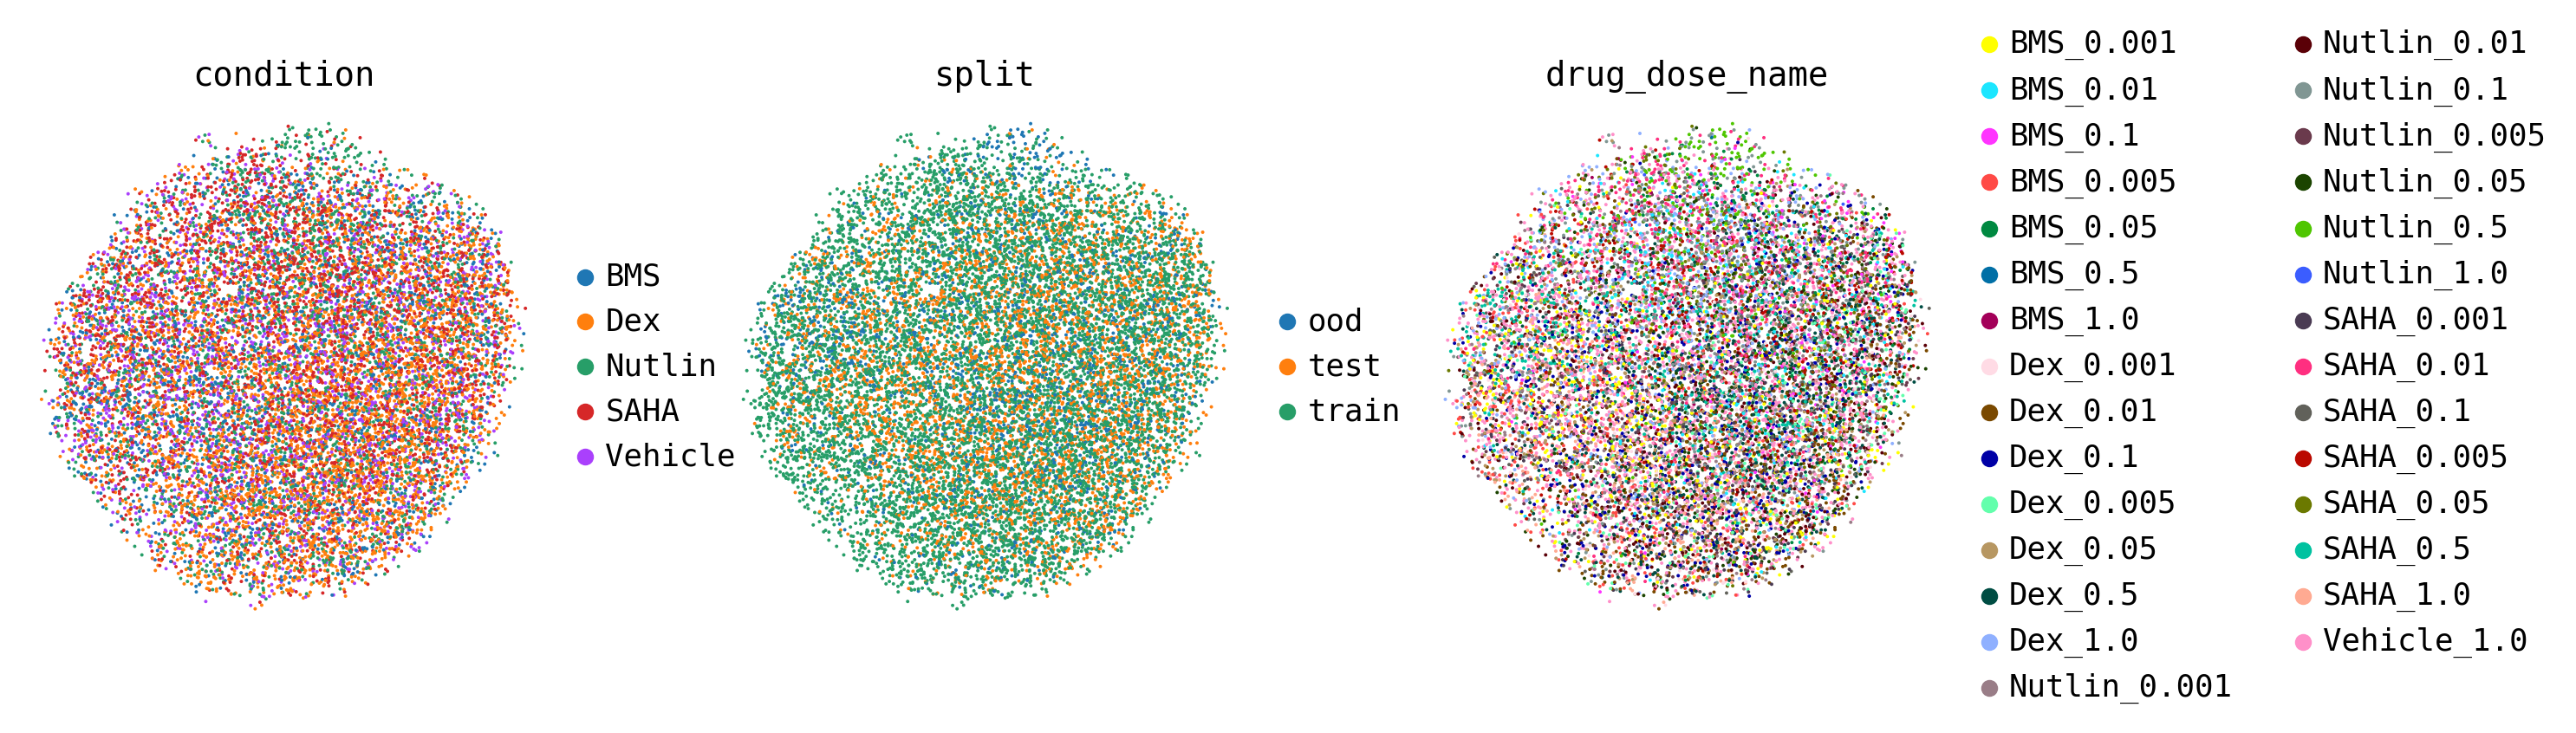

In [42]:
sc.pl.umap(latent_basal_adata, color=['condition', 'split', 'drug_dose_name'], frameon=False, wspace=0.2)

In [43]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


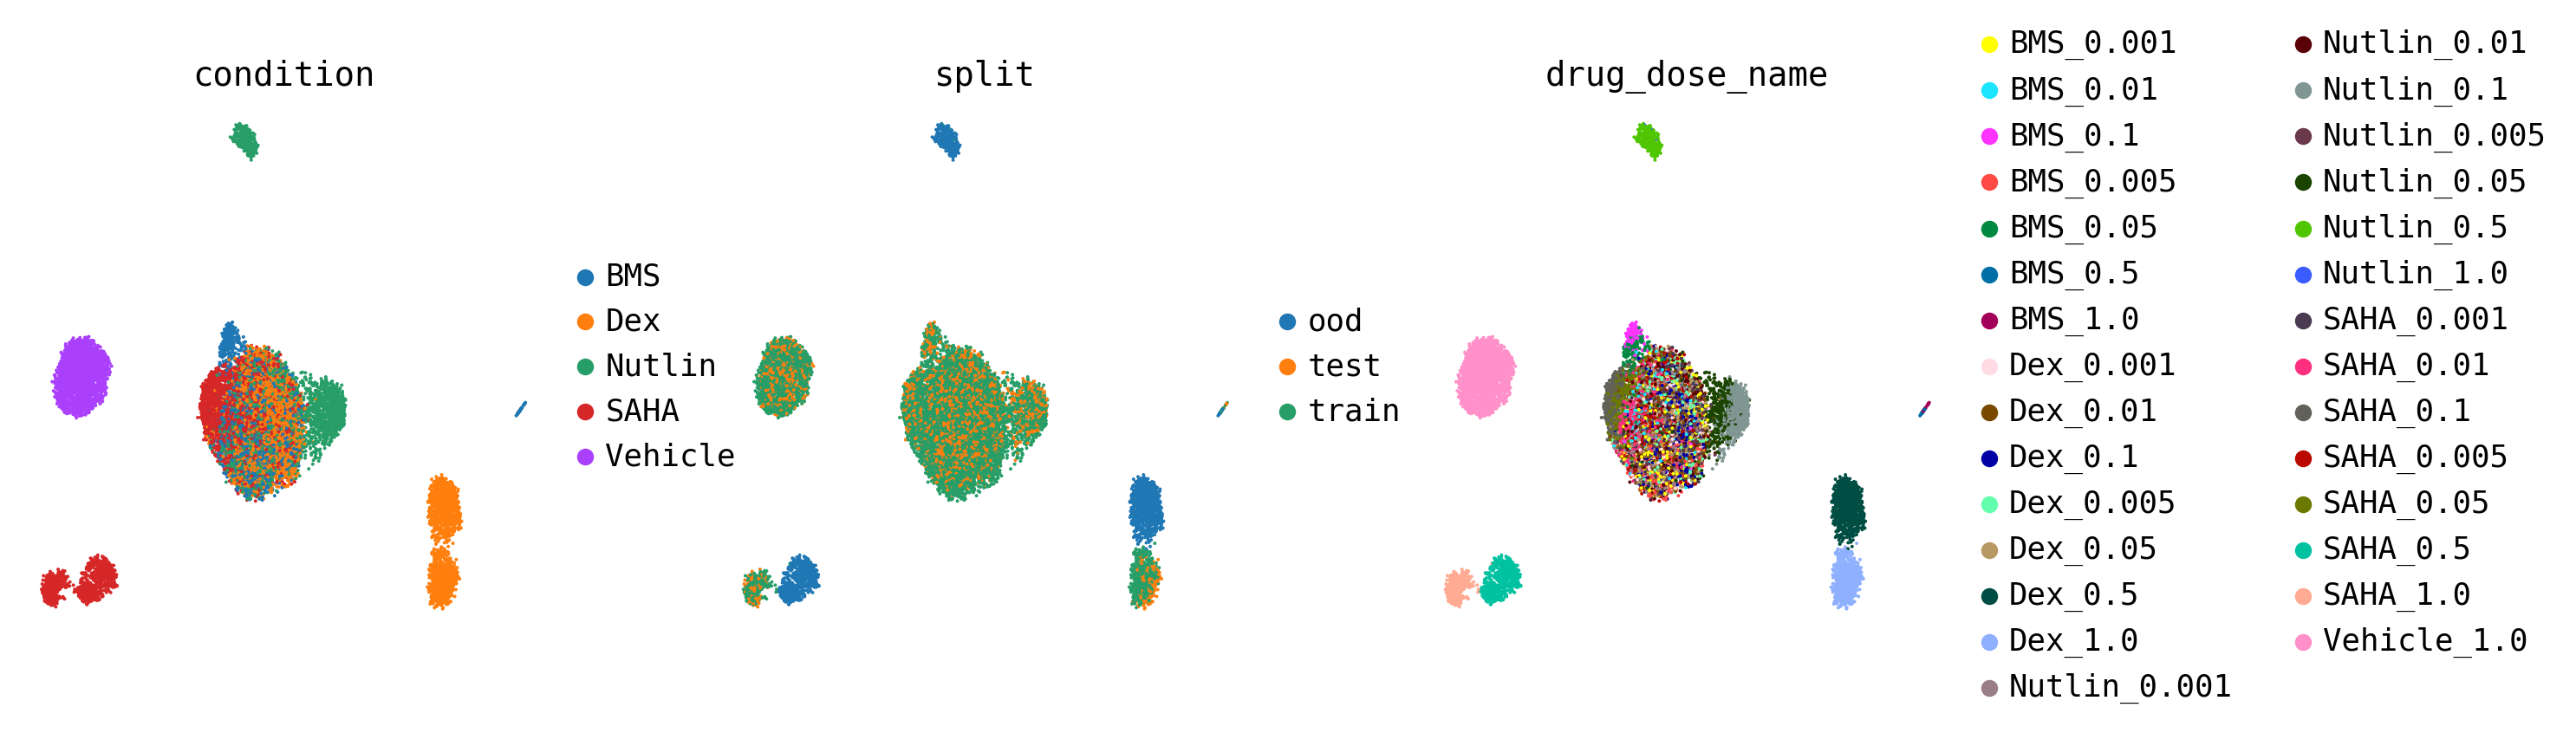

In [44]:
sc.pl.umap(latent_adata, color=['condition', 'split', 'drug_dose_name'], frameon=False, wspace=0.2)

In [45]:
ctrl_mean = adata[adata.obs['control'] == 1].layers['counts'].A.mean(axis=0)
adata.X = np.tile(ctrl_mean, (adata.shape[0], 1))

In [46]:
model.predict(adata, batch_size=1024)

100%|██████████| 15/15 [00:00<00:00, 19.12it/s]


In [47]:
adata.X = np.log1p(adata.layers['counts'].A)
adata.obsm['CPA_pred'] = np.log1p(adata.obsm['CPA_pred'])

Nutlin (2760, 4999)
All genes var:  -0.17939267015742244


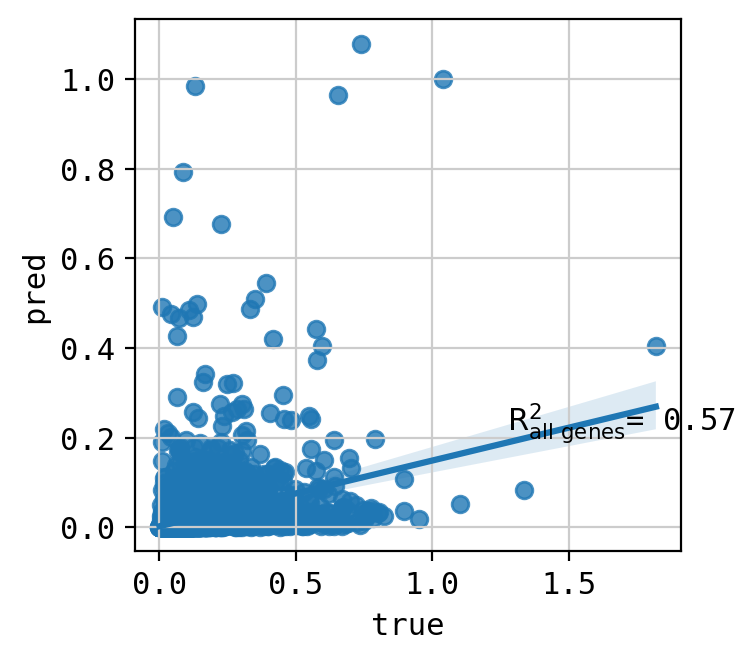

Dex (4468, 4999)
All genes var:  -0.1239629956597279


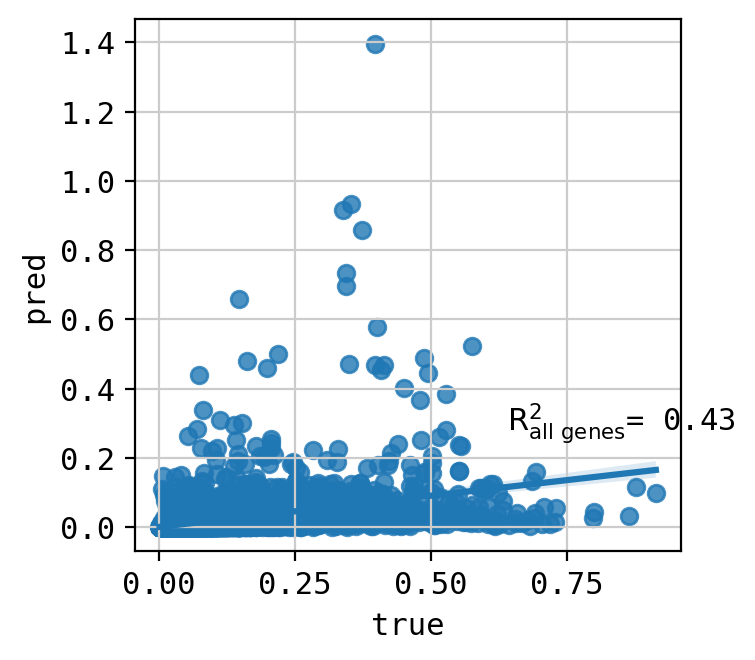

Vehicle (2155, 4999)
All genes var:  -0.47095157040876723


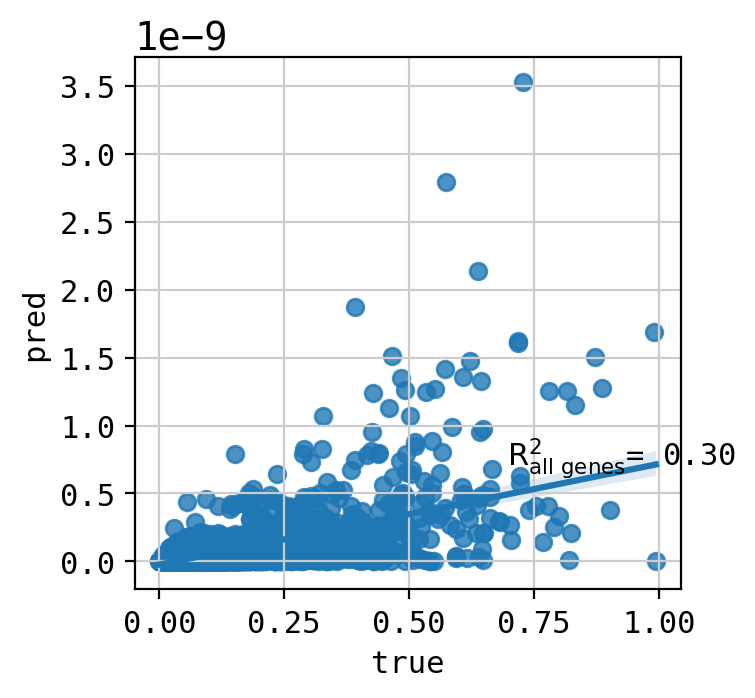

BMS (1939, 4999)
All genes var:  -0.28839839985402715


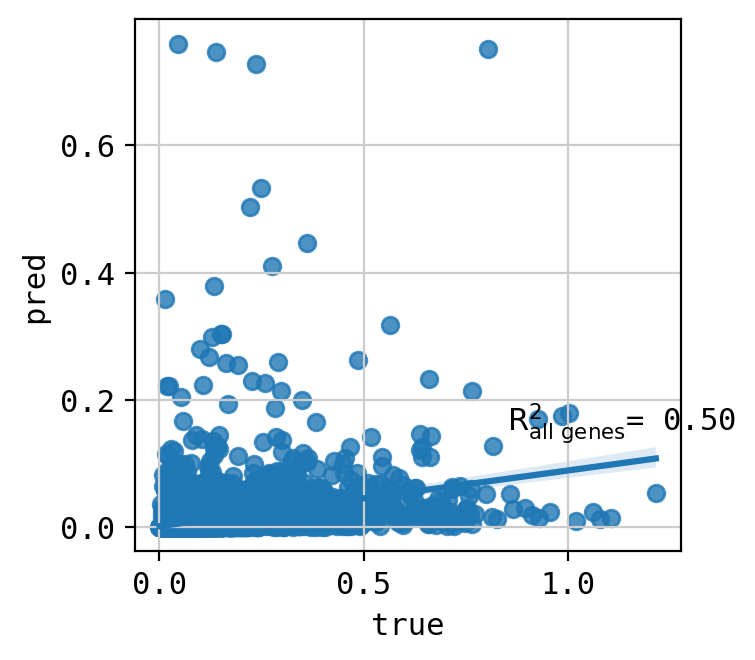

SAHA (3489, 4999)
All genes var:  0.173105985559181


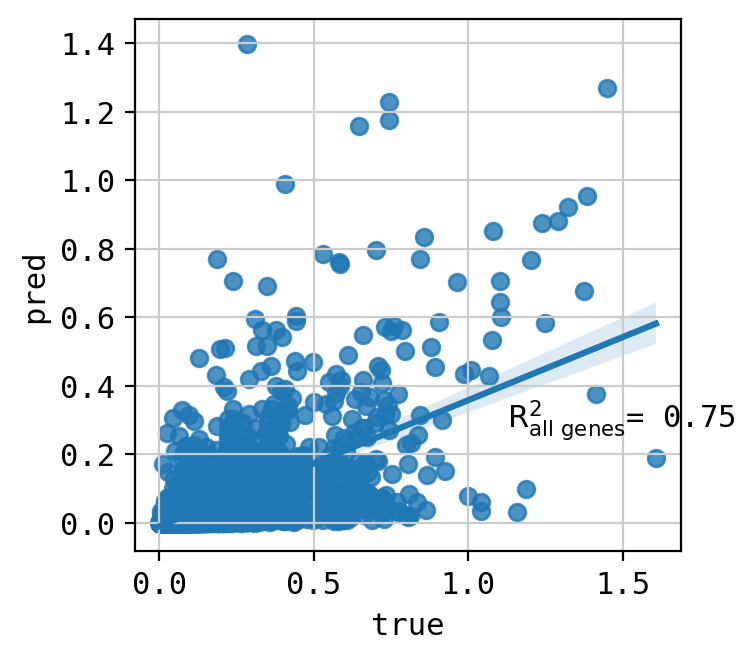

In [48]:
for cat in adata.obs['condition'].unique():
    cat_adata = adata[adata.obs['condition'] == cat].copy()
    print(cat, f'{cat_adata.shape}')
    cpa.pl.mean_plot(cat_adata, 
                     pred_obsm_key='CPA_pred',
                     path_to_save=None,
                     show=True,
                     verbose=True)

## Compert API for compatibility with scanpy

In [33]:
cpa_api = cpa.ComPertAPI(adata, model)

AttributeError: 'CPA' object has no attribute 'drug_encoder'

In [20]:
cpa_plots = cpa.pl.CompertVisuals(cpa_api, fileprefix=None)

In [21]:
cpa_api.num_measured_points['train']

{'A549_BMS_0.001': 442,
 'A549_BMS_0.005': 391,
 'A549_BMS_0.01': 262,
 'A549_BMS_0.05': 134,
 'A549_BMS_0.1': 103,
 'A549_BMS_1.0': 13,
 'A549_Dex_0.001': 204,
 'A549_Dex_0.005': 264,
 'A549_Dex_0.01': 479,
 'A549_Dex_0.05': 484,
 'A549_Dex_0.1': 486,
 'A549_Dex_1.0': 568,
 'A549_Nutlin_0.001': 284,
 'A549_Nutlin_0.005': 252,
 'A549_Nutlin_0.01': 387,
 'A549_Nutlin_0.05': 350,
 'A549_Nutlin_0.1': 457,
 'A549_Nutlin_1.0': 6,
 'A549_SAHA_0.001': 392,
 'A549_SAHA_0.005': 376,
 'A549_SAHA_0.01': 383,
 'A549_SAHA_0.05': 299,
 'A549_SAHA_0.1': 297,
 'A549_SAHA_1.0': 282,
 'A549_Vehicle_1.0': 1535}

In [22]:
drug_adata = cpa_api.get_drug_embeddings()
drug_adata.shape

(5, 64)

In [23]:
adata.obsm['drugs_doses'][:3]

array([[0.   , 0.   , 0.005, 0.   , 0.   ],
       [0.   , 0.5  , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 1.   ]])

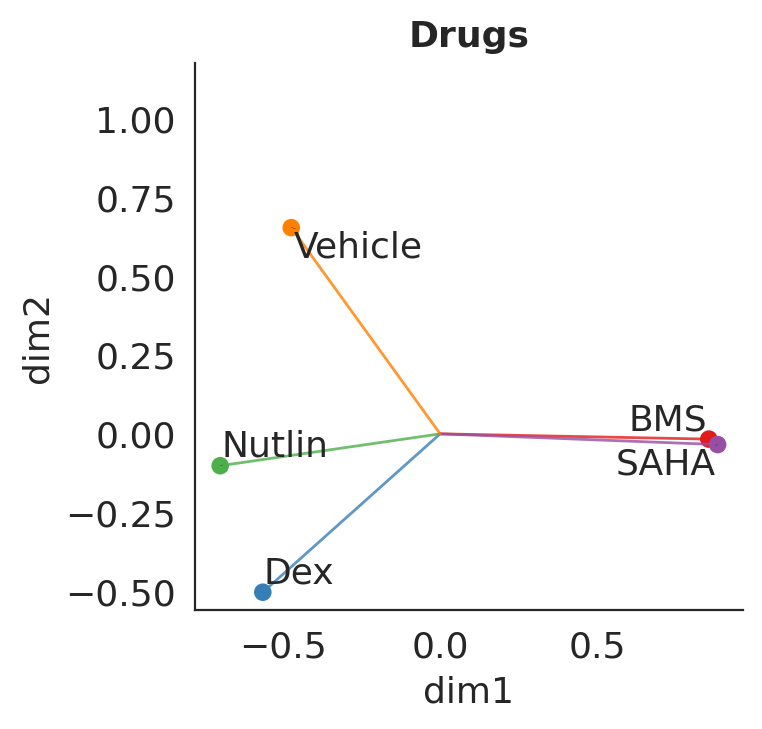

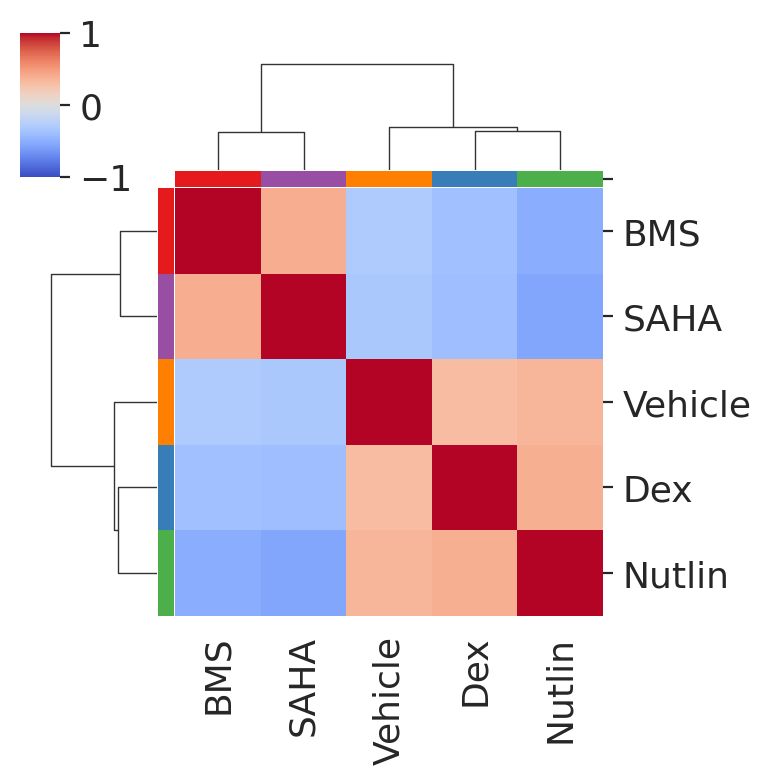

In [24]:
cpa_plots.plot_latent_embeddings(drug_adata.X, kind='perturbations', titlename='Drugs')

In [25]:
cpa_api.compute_comb_emb(thrh=30)

In [26]:
cpa_api.compute_uncertainty(
                    covs=['A549'], 
                    pert='Nutlin', 
                    dose=1.0
                )

(0.018907666, 1.696595, 'A549_Nutlin_0.1', 'A549_Nutlin_0.1')

In [27]:
cpa_api.measured_points['train']

{'A549': {'BMS': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
  'Dex': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
  'Nutlin': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
  'SAHA': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
  'Vehicle': [1.0]}}

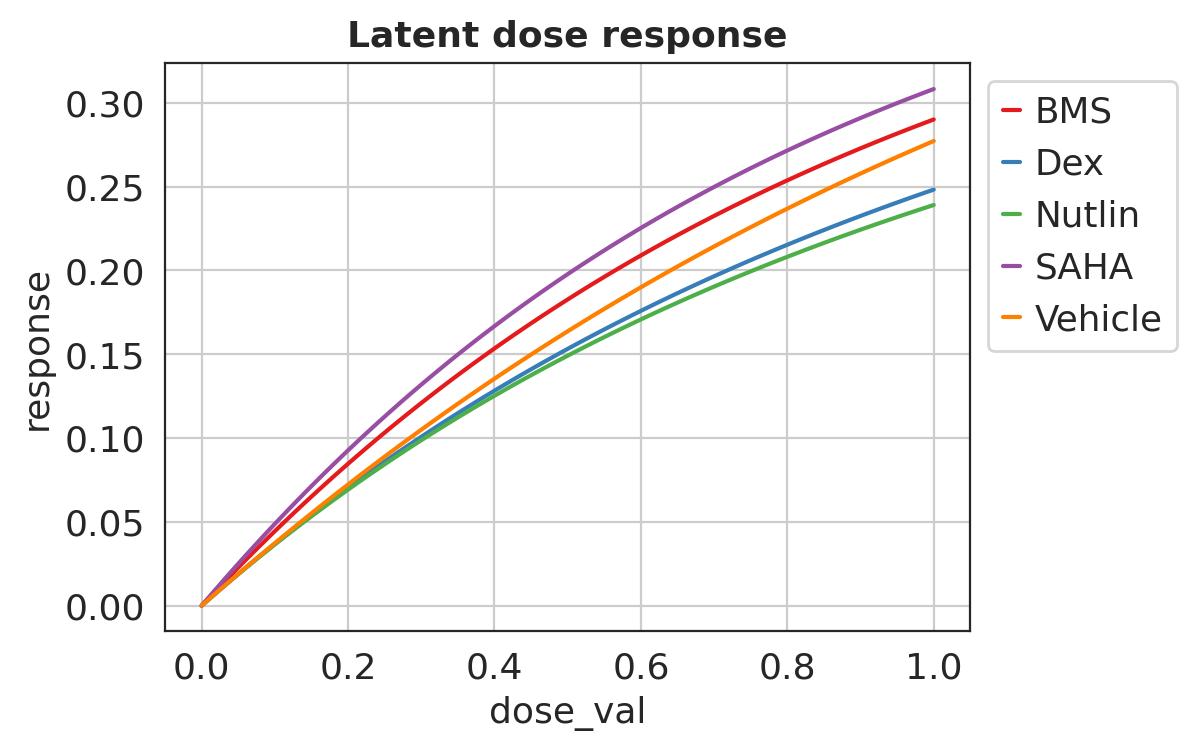

In [28]:
from matplotlib import pyplot as plt
latent_response = cpa_api.latent_dose_response()
cpa_plots.plot_contvar_response(
    latent_response, 
    postfix='latent',
    var_name=cpa_api.perturbation_key,
    title_name='Latent dose response')
plt.legend(bbox_to_anchor=(1.0, 1.0))

In [29]:
scores = cpa_api.evaluate_r2(list(adata[adata.obs['split'] == 'ood'].obs['condition'].unique()))
scores

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting

cell_type condition dose_val   R2_mean  R2_mean_DE    R2_var  R2_var_DE  \
0       A549       BMS    0.001  0.965420    0.942693  0.853268  -0.124010   
1       A549       BMS    0.005  0.955411    0.933723  0.772895  -0.477106   
2       A549       BMS     0.01  0.866992   -0.121568  0.766817  -0.711515   
3       A549       BMS     0.05  0.986432    0.974944  0.937535   0.653853   
4       A549       BMS      0.1  0.989310    0.991250  0.926798   0.870063   
5       A549       BMS      0.5  0.834937    0.895894  0.092573   0.364589   
6       A549       BMS      1.0  0.935394    0.896066  0.709727   0.633140   
7       A549       Dex    0.001  0.957835    0.873165  0.927268   0.220998   
8       A549       Dex    0.005  0.946825    0.584026  0.912667  -0.573487   
9       A549       Dex     0.01  0.954075    0.613295  0.900485  -0.556388   
10      A549       Dex     0.05  0.963540    0.787916  0.897405  -0.939847   
11      A549       Dex      0.1  0.975970    0.882871  0.937024  -0.276247   
12      A549       Dex      0.5  0.994037    0.988758  0.950628   0.794106   
13      A549       Dex      1.0  0.998846    0.997845  0.990567   0.951905   
14      A549    Nutlin    0.001  0.976677    0.975584  0.919390   0.538887   
15      A549    Nutlin    0.005  0.971092    0.924593  0.897736   0.339296   
16      A549    Nutlin     0.01  0.974996    0.971319  0.920241   0.601277   
17      A549    Nutlin     0.05  0.947083    0.912854  0.822474   0.237122   
18      A549    Nutlin      0.1  0.924097    0.846213  0.750278  -0.605287   
19      A549    Nutlin      0.5  0.796542    0.659048  0.668291  -0.096899   
20      A549    Nutlin      1.0  0.814422    0.717284  0.532902  -0.997502   
21      A549      SAHA    0.001  0.970079    0.942010  0.894314   0.292287   
22      A549      SAHA    0.005  0.936937    0.823724  0.873593   0.191957   
23      A549      SAHA     0.01  0.984632    0.962226  0.909599   0.245657   
24      A549      SAHA     0.05  0.997279    0.996339  0.982232   0.958916   
25      A549      SAHA      0.1  0.995649    0.987999  0.981649   0.890244   
26      A549      SAHA      0.5  0.956283    0.869912  0.806909   0.622359   
27      A549      SAHA      1.0  0.996898    0.994075  0.984802   0.916447   

    num_cells  
0         654  
1         542  
2         344  
3         193  
4         153  
5          34  
6          19  
7         327  
8         372  
9         717  
10        694  
11        704  
12        864  
13        790  
14        419  
15        359  
16        567  
17        486  
18        657  
19        265  
20          7  
21        561  
22        519  
23        543  
24        417  
25        426  
26        604  
27        419

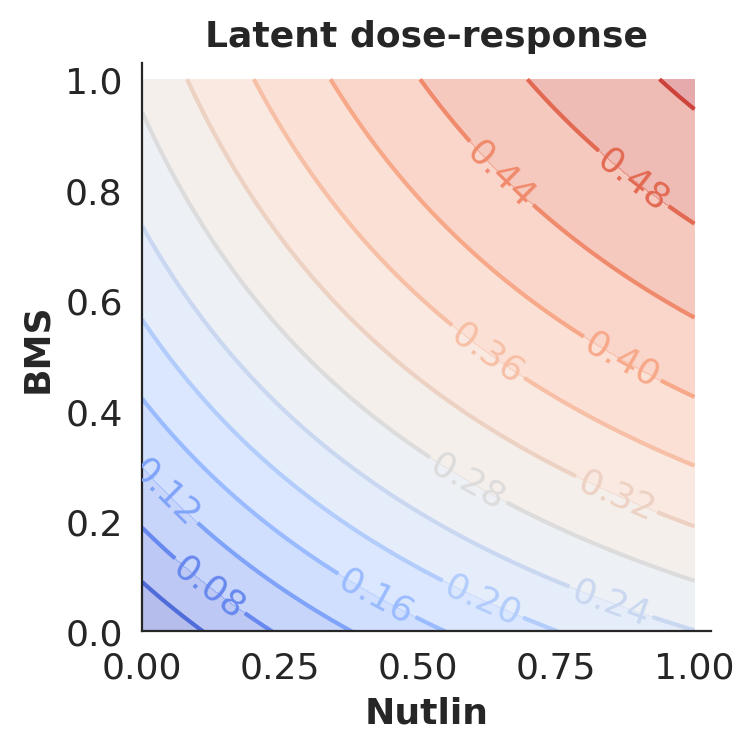

In [30]:
perturbations_pair = ['Nutlin', 'BMS']
latent_dose_2D = cpa_api.latent_dose_response2D(perturbations_pair, n_points=100)
cpa_plots.plot_contvar_response2D(latent_dose_2D, 
        title_name='Latent dose-response')

In [31]:
reconstructed_response2D = cpa_api.get_response2D(['Nutlin', 'BMS'], cpa_api.unique_covars['cell_type'][0])

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting

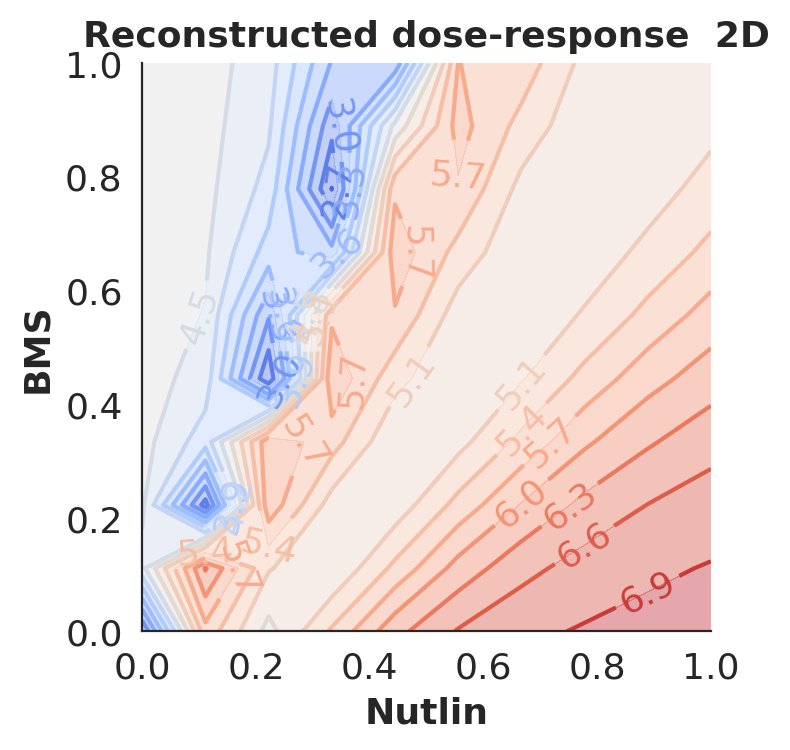

In [32]:
cpa_plots.plot_contvar_response2D(reconstructed_response2D,
                                  title_name='Reconstructed dose-response  2D',
                                  logdose=False,
                                  xlims=(0, 1.0), ylims=(0, 1.0)
                                  )

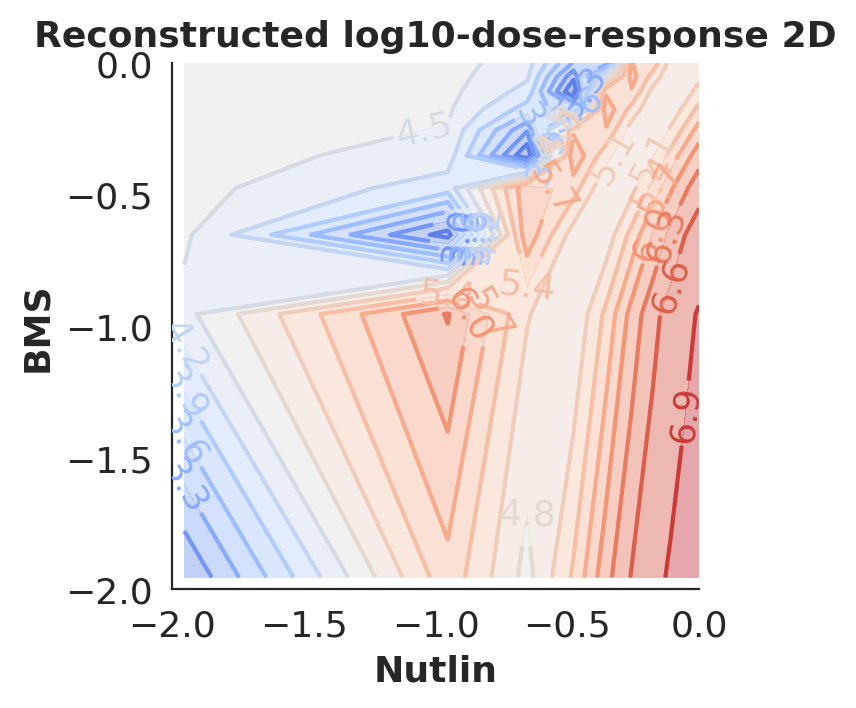

In [33]:
cpa_plots.plot_contvar_response2D(reconstructed_response2D,
                                  title_name='Reconstructed log10-dose-response 2D',
                                  logdose=True,
                                  xlims=(-2, 0), ylims=(-2, 0)
                                  )

In [34]:
# %%time
df_reference = cpa_api.get_response_reference() 

In [35]:
df_reference.head()

cell_type condition  dose_val             split  num_cells  response  \
0      A549       BMS     0.001  training_treated        442  1.774326   
1      A549       BMS     0.005  training_treated        391  2.927792   
2      A549       BMS     0.010  training_treated        262  6.275605   
3      A549       BMS     0.050  training_treated        134  6.652686   
4      A549       BMS     0.100  training_treated        103  5.900538   

      SCYL3  C1orf112      GCLC     STPG1  ...  AL589669.1  AL391117.1  \
0 -0.003192 -0.016493  0.029825 -0.008942  ...    0.002200   -0.008055   
1  0.007327 -0.006961 -0.233149 -0.004181  ...   -0.000393   -0.002095   
2 -0.034505 -0.045197 -0.214411  0.006304  ...    0.004329    0.001807   
3 -0.006467  0.111383 -0.547656  0.005964  ...   -0.004001    0.034350   
4 -0.041323 -0.026907 -0.458251 -0.010185  ...   -0.004001    0.004597   

   AC092718.8  AC015802.6  AC087565.3  AC006511.5  AC079781.5  AL034417.3  \
0    0.000136    0.000687   -0.008671   -0.000800   -0.010130    0.008315   
1   -0.003447   -0.007889   -0.008073    0.011643    0.013168    0.035325   
2   -0.008037   -0.002487    0.008677    0.030816   -0.021999   -0.004749   
3    0.006300    0.003914    0.070792   -0.007431   -0.002193    0.012284   
4   -0.003435    0.013101    0.017064   -0.007431   -0.003163    0.008514   

   AC087269.2  AL358472.5  
0    0.002090    0.000823  
1    0.002095   -0.002024  
2   -0.004152    0.004708  
3   -0.000201    0.011610  
4   -0.005585   -0.006553  

[5 rows x 5005 columns]

In [36]:
# %%time
reconstructed_response = cpa_api.get_response()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


In [37]:
reconstructed_response['source'] = 'pred'
df_reference['source'] = 'true'

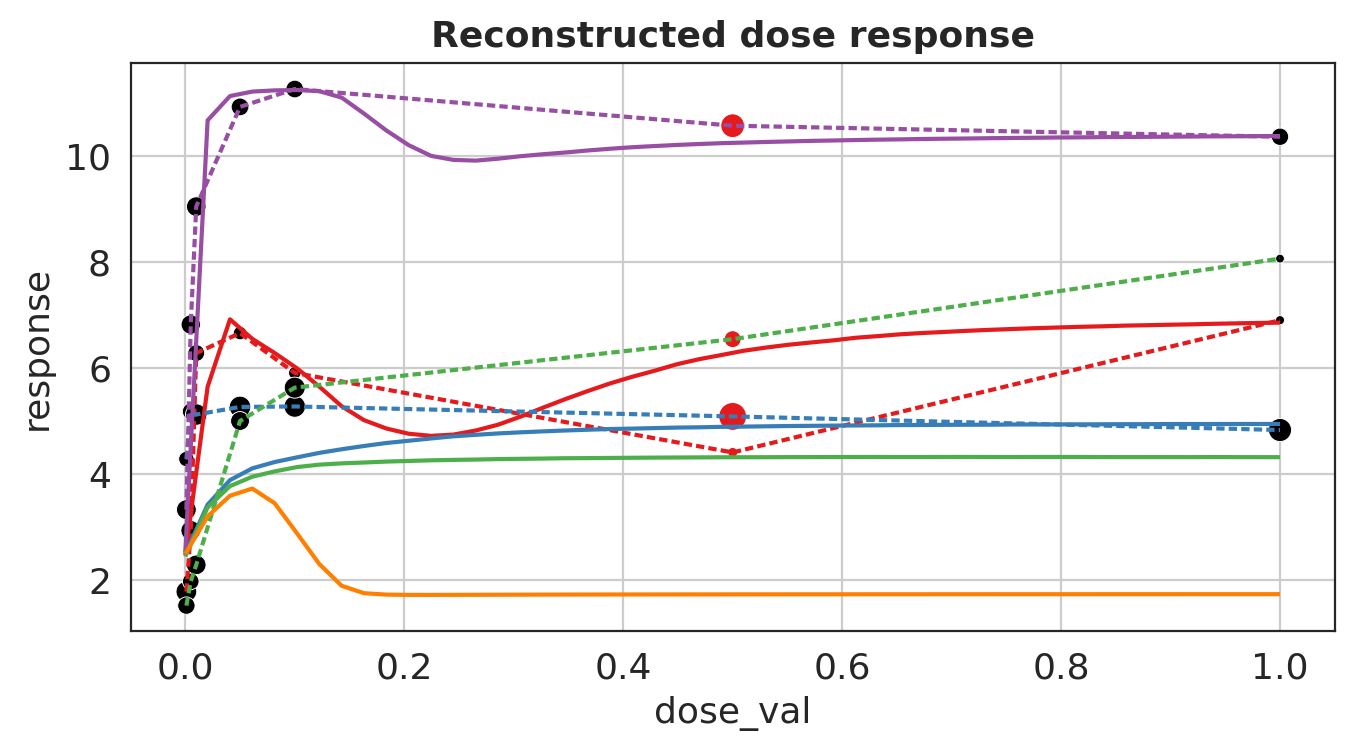

In [38]:
cpa_plots.plot_contvar_response(
    reconstructed_response, 
    df_ref=df_reference, 
    postfix='reconstructed',
    ref_name='source',
    title_name='Reconstructed dose response',
    legend=True,
)

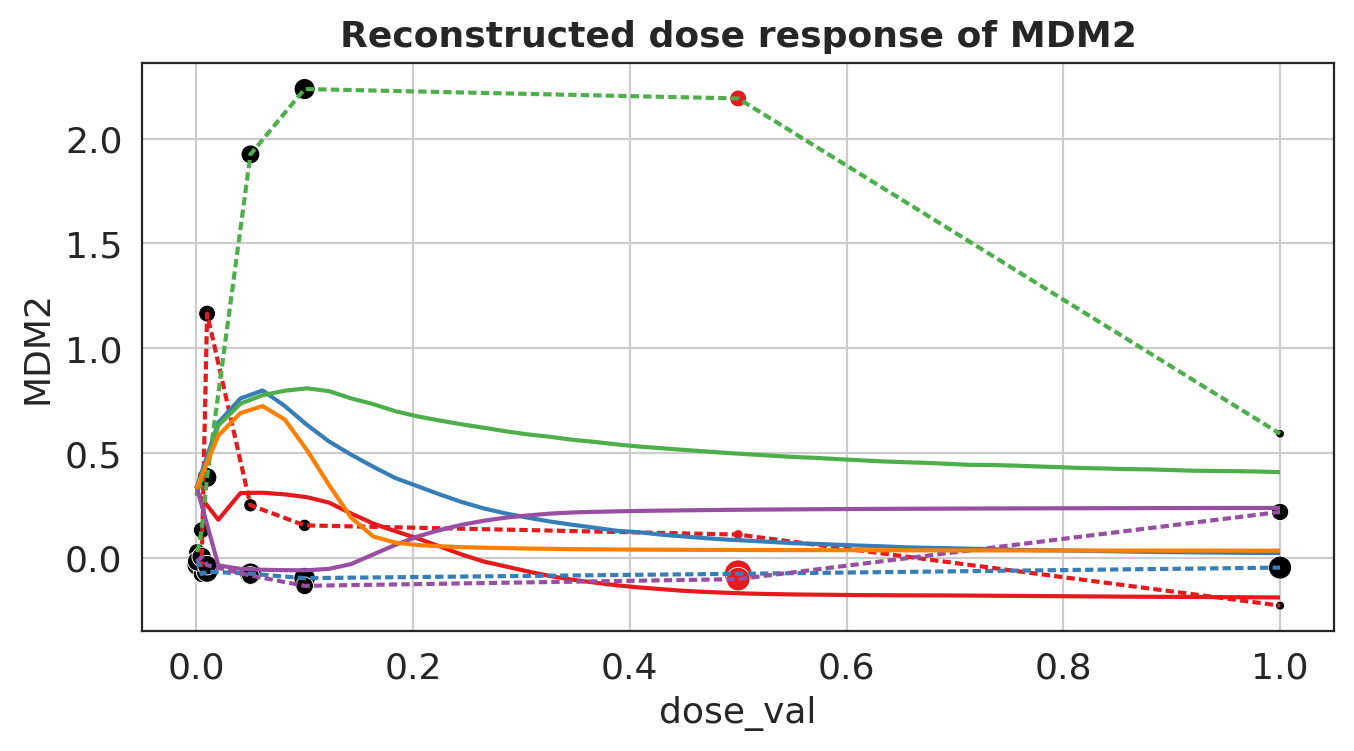

In [39]:
cpa_plots.plot_contvar_response(
    reconstructed_response, 
    df_ref=df_reference,
    response_name='MDM2',
    postfix='MDM2',
    title_name='Reconstructed dose response of MDM2')

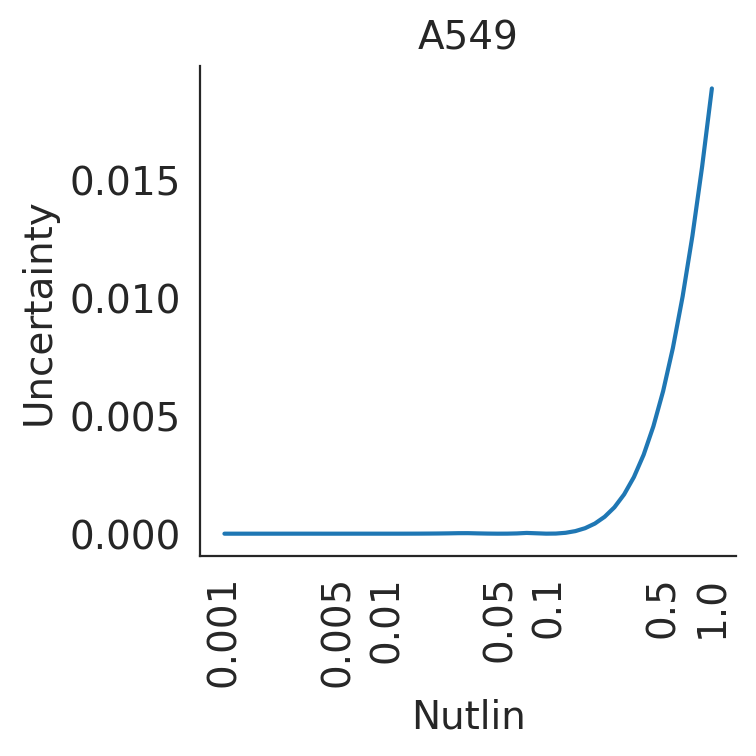

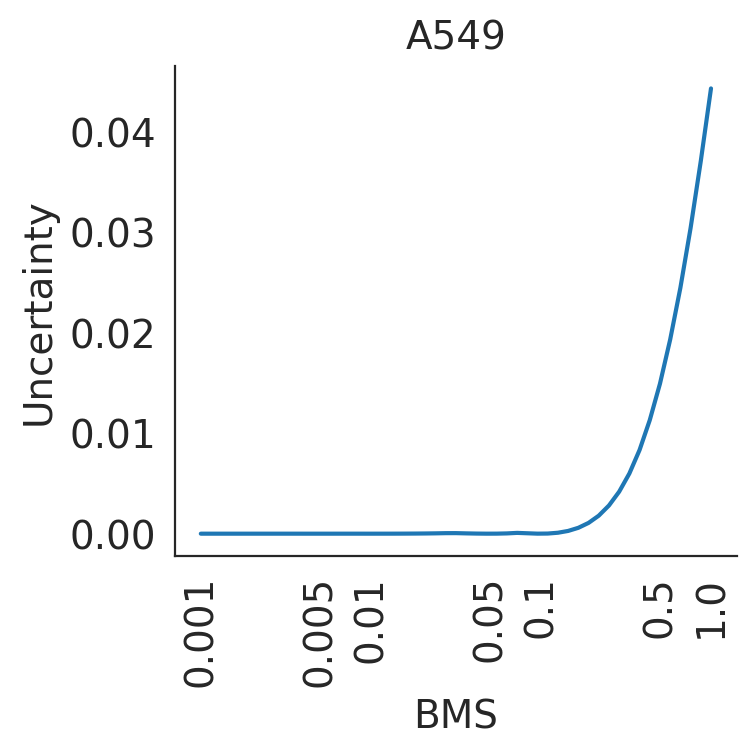

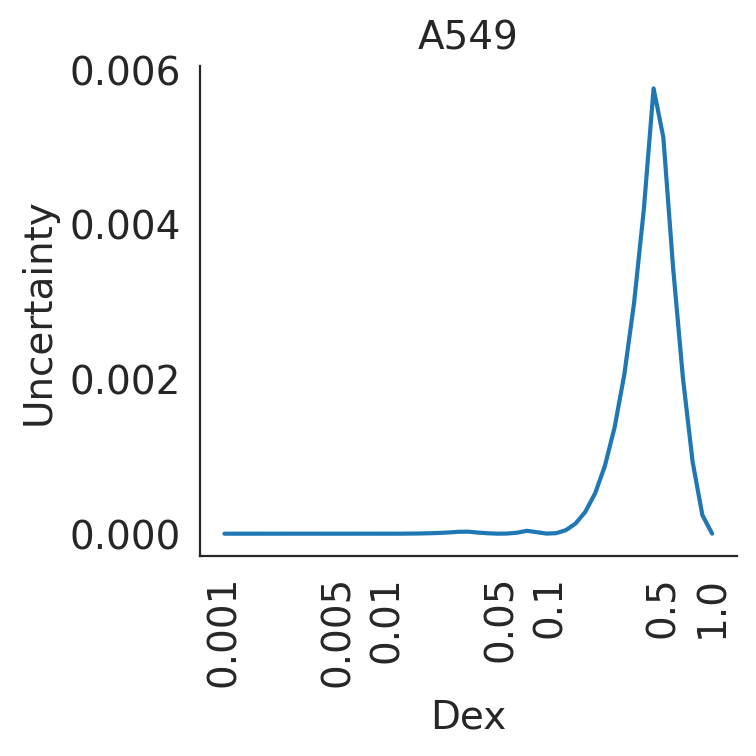

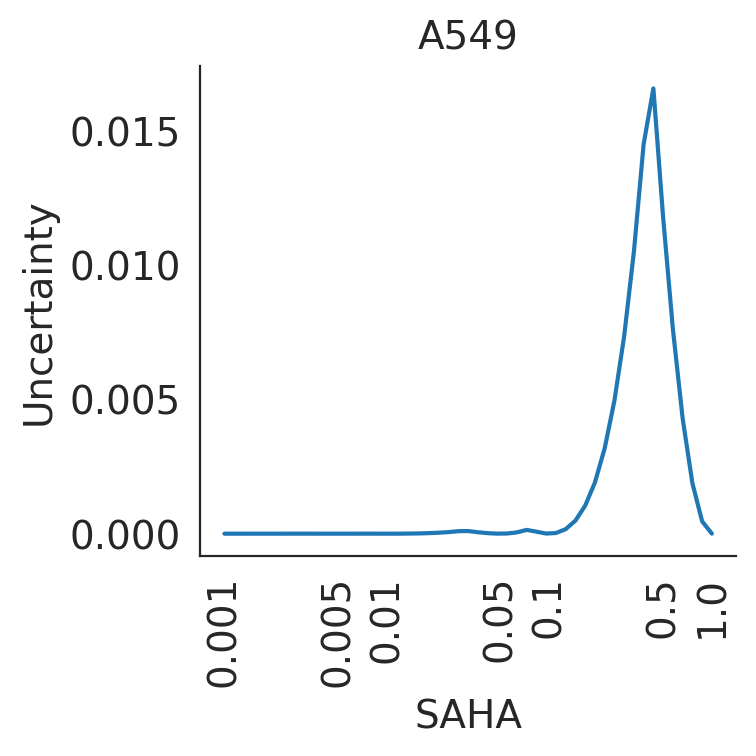

In [40]:
for drug in ['Nutlin', 'BMS', 'Dex', 'SAHA']:
    df_pred = cpa.pl.plot_uncertainty_dose(
        cpa_api,
        cov='A549',
        pert=drug,
        N=51,
        measured_points=cpa_api.measured_points['all'],
        cond_key='condition',
        log=True,
        metric='cosine'
    )